In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import datetime
import os
from torch.utils.tensorboard import SummaryWriter
import shutil
from tqdm.auto import tqdm
from torchsummary import summary

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mean = (0.4467, 0.4398, 0.4066)
std = (0.2603, 0.2566, 0.2713)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


dataset = torchvision.datasets.STL10(root='/content/drive/MyDrive/STL10', split = 'train', download = True,
                                     transform = transform)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = 256, shuffle = True, num_workers = 2)


dataset_test = torchvision.datasets.STL10(root='/content/drive/MyDrive/STL10', split = 'test', download = True,
                                     transform = transform)

testloader = torch.utils.data.DataLoader(dataset_test, batch_size = 256, shuffle = False, num_workers = 2)

current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')

saved_loc = os.path.join('/content/drive/MyDrive/MobileNetV1_Result', current_time)
if os.path.exists(saved_loc):
    shutil.rmtree(saved_loc)
os.mkdir(saved_loc)

print("결과 저장 위치: ", saved_loc)

writer = SummaryWriter(saved_loc)

Files already downloaded and verified
Files already downloaded and verified
결과 저장 위치:  /content/drive/MyDrive/MobileNetV1_Result/2021-07-14-22:12


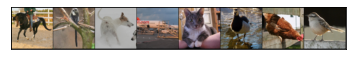

In [4]:
sample, label = next(iter(testloader))

def imshow_grid(img):
    # Denormalization for visualizing sample images.
    img[:, 0, :, :] *= std[0]
    img[:, 1, :, :] *= std[1]
    img[:, 2, :, :] *= std[2]
    img[:, 0, :, :] += mean[0]
    img[:, 1, :, :] += mean[1] 
    img[:, 2, :, :] += mean[2] 
    img = torchvision.utils.make_grid(img.cpu().detach())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()

imshow_grid(sample[0:8])

In [6]:
class MobileNetV1(nn.Module):
    def __init__(self, n_classes, alpha):
        super(MobileNetV1, self).__init__()
        
        assert alpha in {0.25, 0.5, 0.75, 1}

        self.alpha = alpha

        def conv_standard(in_channel, out_channel, s):
            return nn.Sequential(
                nn.Conv2d(int(in_channel), int(out_channel), kernel_size = 3, stride = s, padding = 1, bias = False),
                nn.BatchNorm2d(int(out_channel)),
                nn.ReLU(inplace = True)
            )
    
        def conv_mb(in_channel, out_channel, s):
            return nn.Sequential(
                # Depthwise Convolution
                nn.Conv2d(int(in_channel), int(in_channel), kernel_size = 3, stride = s, padding = 1, groups = int(in_channel), bias = False),
                nn.BatchNorm2d(int(in_channel)),
                nn.ReLU(inplace = True),

                # Pointwise Convolution
                nn.Conv2d(int(in_channel), int(out_channel), kernel_size = 1, stride = 1, padding = 0, bias = False),
                nn.BatchNorm2d(int(out_channel)),
                nn.ReLU(inplace = True),
            )

        self.model = nn.Sequential(
            conv_standard(3, 32 * alpha, 2),
            conv_mb(32 * alpha, 64 * alpha, 1),
            conv_mb(64 * alpha, 128 * alpha, 2),
            conv_mb(128 * alpha, 128 * alpha, 1),
            conv_mb(128 * alpha, 256 * alpha, 2),
            conv_mb(256 * alpha, 256 * alpha, 1),
            conv_mb(256 * alpha, 512 * alpha, 2),
            conv_mb(512 * alpha, 512 * alpha, 1),
            conv_mb(512 * alpha, 512 * alpha, 1),
            conv_mb(512 * alpha, 512 * alpha, 1),
            conv_mb(512 * alpha, 512 * alpha, 1),
            conv_mb(512 * alpha, 512 * alpha, 1),
            conv_mb(512 * alpha, 1024 * alpha, 2),
            conv_mb(1024 * alpha, 1024 * alpha, 1),
            nn.AdaptiveAvgPool2d(1),
            )
        self.fc = nn.Linear(int(1024*alpha), n_classes)
    
    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, int(1024*self.alpha))
        x = self.fc(x)
        return x

model = MobileNetV1(n_classes = 10, alpha = 0.75)


sample_x = torch.randn([1, 3, 224, 224])
print("input shape: ", sample_x.shape)

model.eval()
out = model(sample_x).to(device)
print("output shape: ", out.shape)

model = model.to(device)
summary(model, input_size=(3, 224, 224))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

best_acc = 0

input shape:  torch.Size([1, 3, 224, 224])
output shape:  torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]             216
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              ReLU-6         [-1, 24, 112, 112]               0
            Conv2d-7         [-1, 48, 112, 112]           1,152
       BatchNorm2d-8         [-1, 48, 112, 112]              96
              ReLU-9         [-1, 48, 112, 112]               0
           Conv2d-10           [-1, 48, 56, 56]             432
      BatchNorm2d-11           [-1, 48, 56, 56]              96
             ReLU-12           [-1, 48, 56, 56]               0
           Conv2d-13     

In [7]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_count = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        batch_count += 1

    print("Train Loss : {:.3f} | Train Acc: {:.3f}".format(train_loss / batch_count, 100.*correct/total))
    final_loss = train_loss / batch_count
    final_acc = 100.*correct / total
    return final_loss, final_acc


def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    batch_count = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            batch_count += 1


    print("Test Loss : {:.3f} | Test Acc: {:.3f}".format(test_loss / batch_count, 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(os.path.join(saved_loc, 'checkpoint')):
            os.mkdir(os.path.join(saved_loc, 'checkpoint'))
        torch.save(state, os.path.join(saved_loc, 'checkpoint/ckpt.pth'))
        best_acc = acc
    
    final_loss = test_loss / batch_count
    return final_loss, acc

In [ ]:
for epoch in tqdm(range(50)):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)

    if train_acc == 100.000:
        break

    writer.add_scalars('Graphs/Loss', {"Train Loss" : train_loss, "Test Loss" : test_loss}, epoch)
    writer.add_scalars('Graphs/Accuracy', {"Train acc" : train_acc, "test acc" : test_acc}, epoch)

writer.close()

In [9]:
ckpt = torch.load('/content/drive/MyDrive/MobileNetV1_Result/2021-07-14-22:12/checkpoint/ckpt.pth')

print(ckpt['acc'])
print(ckpt['epoch'])

59.9875
49


In [ ]:

%load_ext tensorboard
%tensorboard --logdir='/content/drive/MyDrive/MobileNetV1_Result/2021-07-14-22:12'